# 9.523 Project


First need to run this to install torch and torchvison


In [0]:
# Initialize notebook.
!pip install -qU plotly torch torchvision 
!pip install -qU Pillow==4.1.1

Run this to mount google drive to save results to my drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

All of the libraries needed

In [0]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models

import math
from scipy.ndimage.filters import gaussian_filter

import copy
from PIL import Image
import matplotlib.cm as mpl_color_map

from torch.autograd import Variable
import matplotlib.pyplot as plt
import pickle

cuda = torch.device('cuda')  

Helper functions for visualiztion program

In [0]:
def save_image(im, path):
    """
        Saves a numpy matrix of shape D(1 or 3) x W x H as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, np.ndarray):
        if len(im.shape) == 2:
            im = np.expand_dims(im, axis=0)
        if im.shape[0] == 1:
            # Converting an image with depth = 1 to depth = 3, repeating the same values
            # For some reason PIL complains when I want to save channel image as jpg without
            # additional format in the .save()
            im = np.repeat(im, 3, axis=0)
            # Convert to values to range 1-255 and W,H, D
        if im.shape[0] == 3:
            im = im.transpose(1, 2, 0) * 255
        im = Image.fromarray(im.astype(np.uint8))
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((512, 512))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float().cuda()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.cpu().data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

Main code for visualization

In [0]:
class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter, blur_radius, blur_every, remove_colors = None):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        self.blur_radius = blur_radius
        self.blur_every = 5
        self.remove_colors = remove_colors
        # Generate a random image
        self.created_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]

        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self, folder_name):
        # Hook the selected layer
        self.hook_layer()
        # Process image and return variable
        self.processed_image = preprocess_image(self.created_image, False)
        # Define optimizer for the image
        optimizer = Adam([self.processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 51):
            optimizer.zero_grad()
            
            if self.remove_colors != None:
                with torch.no_grad():
                    self.processed_image[:,self.remove_colors[0],:,:] = 0
                    self.processed_image[:,self.remove_colors[1],:,:] = 0
                    
            # Assign create image to a variable to move forward in the model        
            x = self.processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
                    
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)

            # Backward
            loss.backward()

            # Update image
            optimizer.step()
            
            # Recreate image
            with torch.no_grad():
                if self.remove_colors != None:
                    mean = [0.485, 0.456, 0.406]
                    self.processed_image[:,self.remove_colors[0],:,:] = -mean[self.remove_colors[0]]
                    self.processed_image[:,self.remove_colors[1],:,:] = -mean[self.remove_colors[1]]
        
                if self.blur_every is not 0 and self.blur_radius > 0:
                    if i % self.blur_every == 0:
                        for channel in range(3):
                            cimg = gaussian_filter(self.processed_image[:,channel,:,:].cpu().detach().numpy(), self.blur_radius)
                            self.processed_image[:,channel,:,:] = torch.tensor(cimg).cuda()
            # Save image
            if i % 50 == 0:
                self.created_image = recreate_image(self.processed_image)
                print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.cpu().data.numpy()))
                im_path = '/content/gdrive/My Drive/generated/' + folder_name + '/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '.jpg'
                save_image(self.created_image, im_path)
                return -loss.item()
              
    def get_activations(self, image, filter):
        self.hook_layer()

        self.processed_image = preprocess_image(image, False)
        
        with torch.no_grad():
            x = self.processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break

        return x[0,filter,:,:] 
        

In [0]:
cnn_layer = 18
blur_radius = .75
blur_every = 4
filter_pos = 11
colors_to_remove = None
pretrained_model = models.vgg19(pretrained=True).cuda().features
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos, blur_radius, blur_every, colors_to_remove)

In [0]:
border = torch.zeros(28,13).cuda()

In [0]:
from scipy.ndimage import rotate

In [0]:
import cv2
def zoom(img, zoom_factor):
    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    Args:
        img : Image array
        zoom_factor : amount of zoom as a ratio (0 to Inf)
    """
    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

In [0]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    unravelled = np.unravel_index(indices, ary.shape)
    return list(zip(unravelled[0], unravelled[1]))

def act_to_im(i,j):
#     return (8*i - 16, 8*i + 24), (8*j - 16, 8*j + 24)
    return (8*i - 8, 8*i + 16), (8*j - 8, 8*j + 16)
  
def get_NF(activations, image, N):
    NF = np.zeros((24,24,3), dtype = np.float64)
    max_act = torch.max(activations).item()
    Z = N * max_act
    
    max_indices = largest_indices(activations, N)
    
    for i,j in max_indices:
        (a,b), (c,d) = act_to_im(i,j)
        NF += activations[i,j].item() * image[a:b,c:d,:]
    NF /= Z
    return np.uint8(NF)
  
def get_NFsamples(activations, image, N):
    NF = np.zeros((24,10,3), dtype = np.uint8) * 255
    border = np.zeros((24,10,3), dtype = np.uint8) * 255
    max_act = torch.max(activations).item()
#     Z = N * max_act
    
    max_indices = largest_indices(activations, N)
    
    for i,j in max_indices:
        (a,b), (c,d) = act_to_im(i,j)
        NF = np.concatenate((NF, image[a:b,c:d,:]), axis=1)
        NF = np.concatenate((NF, border), axis=1)
    return np.uint8(NF)

tensor(61.5791, device='cuda:0')
tensor(61.8681, device='cuda:0')
tensor(47.5740, device='cuda:0')
tensor(124.5634, device='cuda:0')


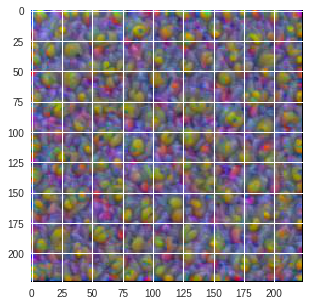

In [0]:
plt.rcParams['figure.figsize'] = [10, 5]
filter_pos = "57"
filter_num = 57

lt = 100
rt = 125
up = 75
dn = 100

lt = 0
rt = -1
up = 0
dn = -1

angle = 0
times = 1

image_g = plt.imread("/content/gdrive/My Drive/generated/blurred_green/layer_vis_l18_f" + filter_pos + ".jpg")

image_g2 = np.zeros((224,224,3), dtype = np.uint8)
image_g2[lt:rt,up:dn,:] = image_g[lt:rt,up:dn,:]

# plt.imshow(zoom(rotate(image2, angle), times))

g = layer_vis.get_activations(zoom(rotate(image_g2, angle), times), filter_num)

image_r = plt.imread("/content/gdrive/My Drive/generated/blurred_red/layer_vis_l18_f" + filter_pos + ".jpg")

image_r2 = np.zeros((224,224,3), dtype = np.uint8)
image_r2[lt:rt,up:dn,:] = image_r[lt:rt,up:dn,:]

# image2 = image2[:,:,[1,0,2]]
# plt.imshow(zoom(rotate(image2, angle), times))

r = layer_vis.get_activations(zoom(rotate(image_r2, angle), times), filter_num)

image_b = plt.imread("/content/gdrive/My Drive/generated/blurred_blue/layer_vis_l18_f" + filter_pos + ".jpg")

image_b2 = np.zeros((224,224,3), dtype = np.uint8)
image_b2[lt:rt,up:dn,:] = image_b[lt:rt,up:dn,:]

# image2 = image2[:,:,[2,1,0]]
# plt.imshow(zoom(rotate(image2, angle), times))

b = layer_vis.get_activations(zoom(rotate(image_b2, angle), times), filter_num)

image_a = plt.imread("/content/gdrive/My Drive/generated/blurred/layer_vis_l18_f" + filter_pos + ".jpg")

image_a2 = np.zeros((224,224,3), dtype = np.uint8)
image_a2[lt:rt,up:dn,:] = image_a[lt:rt,up:dn,:]

# image2[100:150,100:150,1] = 255
# image2[110:140,110:140,1] = 0

# image2[110:140,110:140,0] = 255
# image2[120:130,120:130,0] = 0
# image2[120:130,120:130,2] = 255

# image2[105:115,105:115,0] = 255
# image2[100:125,100:125,0] = 255
a = layer_vis.get_activations(zoom(rotate(image_a2, angle), times), filter_num)
print(torch.max(r))
print(torch.max(g))
print(torch.max(b))
print(torch.max(a))
# a[0:2,:] = a[26:28,:] = a[:, 0:2] = a[:, 26:28] = 0
plt.imshow(zoom(rotate(image2, angle), times))

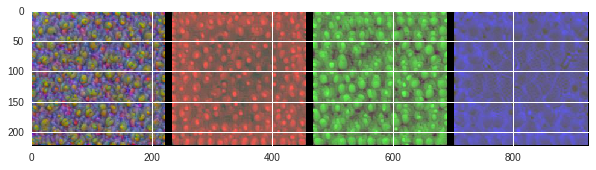

In [0]:
plt.rcParams['figure.figsize'] = [10, 5]
filter_pos = "57"
filter_num = 57

lt = 100
rt = 125
up = 75
dn = 100

lt = 0
rt = -1
up = 0
dn = -1

angle = 0
times = 1

image_g = plt.imread("/content/gdrive/My Drive/generated/blurred_green/layer_vis_l18_f" + filter_pos + ".jpg")
image_g2 = np.zeros((224,224,3), dtype = np.uint8)
image_g2[lt:rt,up:dn,:] = image_g[lt:rt,up:dn,:]
image_gf = zoom(rotate(image_g2, angle), times)

g = layer_vis.get_activations(image_gf, filter_num)

image_r = plt.imread("/content/gdrive/My Drive/generated/blurred_red/layer_vis_l18_f" + filter_pos + ".jpg")
image_r2 = np.zeros((224,224,3), dtype = np.uint8)
image_r2[lt:rt,up:dn,:] = image_r[lt:rt,up:dn,:]
image_rf = zoom(rotate(image_r2, angle), times)
r = layer_vis.get_activations(image_rf, filter_num)

image_b = plt.imread("/content/gdrive/My Drive/generated/blurred_blue/layer_vis_l18_f" + filter_pos + ".jpg")
image_b2 = np.zeros((224,224,3), dtype = np.uint8)
image_b2[lt:rt,up:dn,:] = image_b[lt:rt,up:dn,:]
image_bf = zoom(rotate(image_b2, angle), times)
b = layer_vis.get_activations(image_bf, filter_num)

image_a = plt.imread("/content/gdrive/My Drive/generated/blurred/layer_vis_l18_f" + filter_pos + ".jpg")
image_a2 = np.zeros((224,224,3), dtype = np.uint8)
image_a2[lt:rt,up:dn,:] = image_a[lt:rt,up:dn,:]
image_af = zoom(rotate(image_a2, angle), times) 
a = layer_vis.get_activations(image_af, filter_num)

max_acts = [torch.max(a).item(), torch.max(r).item(), torch.max(g).item(), torch.max(b).item()]
avg_acts = [torch.mean(a).item(), torch.mean(r).item(), torch.mean(g).item(), torch.mean(b).item()]

acts = {"max" : max_acts, "avg" : avg_acts}
# pickle.dump(acts, open("/content/gdrive/My Drive/generated/analysis/" + filter_pos + "/acts.p", "wb" ) )

border = np.zeros((224, 10, 3), dtype = np.uint8)
image_all = np.concatenate((image_af, border, image_rf, border, image_gf, border, image_bf), axis = 1)
plt.imshow(image_all)

im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/all_images.jpg'
# save_image(image_all, im_path)

In [0]:
filter_pos = "57"
acts = pickle.load( open("/content/gdrive/My Drive/generated/analysis/" + filter_pos + "/acts.p", "rb" ) )

In [0]:
acts

{'avg': [17.819562911987305,
  18.346118927001953,
  4.909552574157715,
  33.91035079956055],
 'max': [61.57905578613281,
  61.86814880371094,
  47.57395935058594,
  124.56338500976562]}

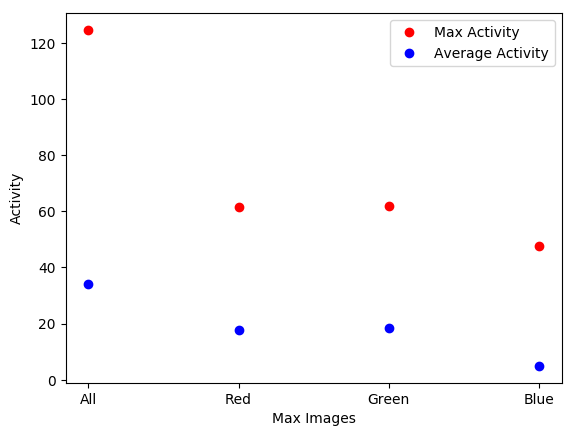

In [0]:
plt.style.use('default')
fig = plt.figure()

x = np.array([0,1,2,3])
y1 = acts["avg"]
y2 = acts["max"]
my_xticks = ['All','Red','Green','Blue']
plt.xticks(x, my_xticks)
plt.plot(x, y2, "ro", y1, "bo")
plt.ylabel("Activity")
plt.xlabel("Max Images")
plt.legend(["Max Activity", "Average Activity"])
plt.show()
im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/act_plot.jpg'
plt.savefig(im_path)

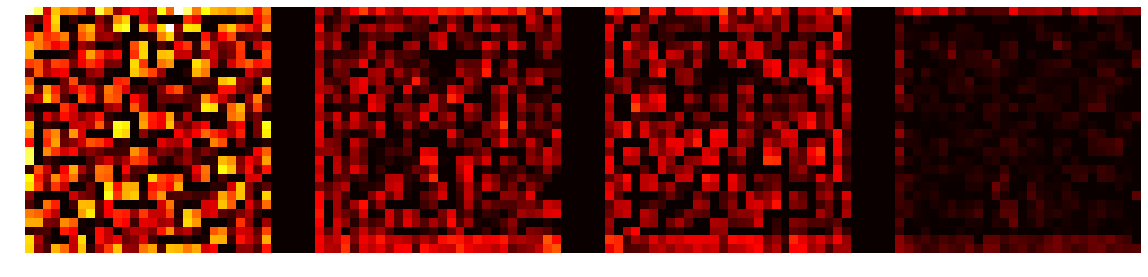

In [0]:
border = torch.zeros(28,5).cuda()
plt.rcParams['figure.figsize'] = [20, 10]
c = torch.cat((a, border, r, border, g, border, b), dim = 1)
c /= torch.max(c)
fig = plt.figure(frameon=False)
plt.axis('off')
plt.imshow(c, cmap='hot', interpolation='nearest')
im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/act_images.jpg'
# plt.imsave(im_path, c, cmap='hot')
plt.savefig(im_path, dpi = 50, bbox_inches='tight', pad_inches=0)

In [0]:
g_gf = image_gf
g_bf = image_gf[:,:,[0,2,1]]
g_rf = image_gf[:,:,[1,0,2]]
g_g = layer_vis.get_activations(g_gf, filter_num)
g_b = layer_vis.get_activations(g_bf, filter_num)
g_r = layer_vis.get_activations(g_rf, filter_num)

g_max_acts = [torch.max(g_r).item(), torch.max(g_g).item(), torch.max(g_b).item()]
g_avg_acts = [torch.mean(g_r).item(), torch.mean(g_g).item(), torch.mean(g_b).item()]

g_acts = {"max" : g_max_acts, "avg" : g_avg_acts}
# pickle.dump(g_acts, open("/content/gdrive/My Drive/generated/analysis/" + filter_pos + "/g_acts.p", "wb" ) )

# print(g_acts)

# border = np.zeros((224, 10, 3), dtype = np.uint8)
# g_image_all = np.concatenate((g_rf, border, g_gf, border, g_bf), axis = 1)
# # plt.imshow(g_image_all)

# im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/g_all_images.jpg'
# save_image(g_image_all, im_path)

# border = torch.zeros(28,5).cuda()
# plt.rcParams['figure.figsize'] = [20, 10]
# g_c = torch.cat((g_r, border, g_g, border, g_b), dim = 1)
# g_c /= torch.max(g_c)

# fig = plt.figure(frameon=False)
# plt.axis('off')

# plt.imshow(g_c, cmap='hot', interpolation='nearest')
# im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/g_act_images.jpg'
# # plt.imsave(im_path, g_c, cmap='hot')
# plt.savefig(im_path, dpi = 50, bbox_inches='tight', pad_inches=0)


In [0]:
r_rf = image_rf
r_gf = image_rf[:,:,[1,0,2]]
r_bf = image_rf[:,:,[2,1,0]]

r_g = layer_vis.get_activations(r_gf, filter_num)
r_b = layer_vis.get_activations(r_bf, filter_num)
r_r = layer_vis.get_activations(r_rf, filter_num)

r_max_acts = [torch.max(r_r).item(), torch.max(r_g).item(), torch.max(r_b).item()]
r_avg_acts = [torch.mean(r_r).item(), torch.mean(r_g).item(), torch.mean(r_b).item()]

r_acts = {"max" : r_max_acts, "avg" : r_avg_acts}
# pickle.dump(r_acts, open("/content/gdrive/My Drive/generated/analysis/" + filter_pos + "/r_acts.p", "wb" ) )

# print(r_acts)

# border = np.zeros((224, 10, 3), dtype = np.uint8)
# r_image_all = np.concatenate((r_rf, border, r_gf, border, r_bf), axis = 1)
# # plt.imshow(r_image_all)

# im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/r_all_images.jpg'
# save_image(r_image_all, im_path)

# border = torch.zeros(28,5).cuda()
# plt.rcParams['figure.figsize'] = [20, 10]
# r_c = torch.cat((r_r, border, r_g, border, r_b), dim = 1)
# r_c /= torch.max(r_c)

# fig = plt.figure(frameon=False)
# plt.axis('off')
# plt.imshow(r_c, cmap='hot', interpolation='nearest')
# im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/r_act_images.jpg'
# # plt.imsave(im_path, r_c, cmap='hot')
# plt.savefig(im_path, dpi = 50, bbox_inches='tight', pad_inches=0)

In [0]:
b_bf = image_bf
b_rf = image_bf[:,:,[2,1,0]]
b_gf = image_bf[:,:,[0,2,1]]


b_g = layer_vis.get_activations(b_gf, filter_num)
b_b = layer_vis.get_activations(b_bf, filter_num)
b_r = layer_vis.get_activations(b_rf, filter_num)

b_max_acts = [torch.max(b_r).item(), torch.max(b_g).item(), torch.max(b_b).item()]
b_avg_acts = [torch.mean(b_r).item(), torch.mean(b_g).item(), torch.mean(b_b).item()]

b_acts = {"max" : b_max_acts, "avg" : b_avg_acts}
# pickle.dump(b_acts, open("/content/gdrive/My Drive/generated/analysis/" + filter_pos + "/b_acts.p", "wb" ) )

# print(b_acts)

# border = np.zeros((224, 10, 3), dtype = np.uint8)
# b_image_all = np.concatenate((b_rf, border, b_gf, border, b_bf), axis = 1)
# # plt.imshow(b_image_all)

# im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/b_all_images.jpg'
# save_image(b_image_all, im_path)

# border = torch.zeros(28,5).cuda()
# plt.rcParams['figure.figsize'] = [20, 10]
# b_c = torch.cat((b_r, border, b_g, border, b_b), dim = 1)
# b_c /= torch.max(b_c)

# fig = plt.figure(frameon=False)
# plt.axis('off')
# plt.imshow(b_c, cmap='hot', interpolation='nearest')
# im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/b_act_images.jpg'
# # plt.imsave(im_path, b_c, cmap='hot')

# plt.savefig(im_path, dpi = 50, bbox_inches='tight', pad_inches=0)

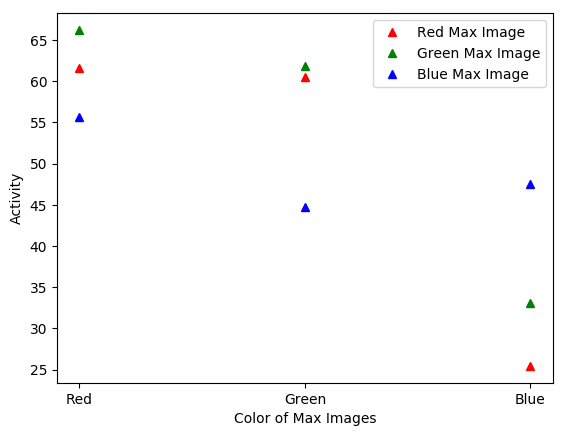

In [0]:
plt.style.use('default')
fig = plt.figure()

x = np.array([0,1,2])
my_xticks = ['Red','Green','Blue']
plt.xticks(x, my_xticks)

plt.plot(x, r_acts["max"], "r^", g_acts["max"], "g^",b_acts["max"], "b^")
# plt.plot(x, r_acts["max"], "r^", r_acts["avg"], "ro", g_acts["max"], "g^", g_acts["avg"], "go", b_acts["max"], "b^", b_acts["avg"], "bo")
plt.ylabel("Activity")
plt.xlabel("Color of Max Images")
plt.legend(["Red Max Image", "Green Max Image", "Blue Max Image"])
plt.show()
# im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/act_plot.jpg'
# plt.savefig(im_path)

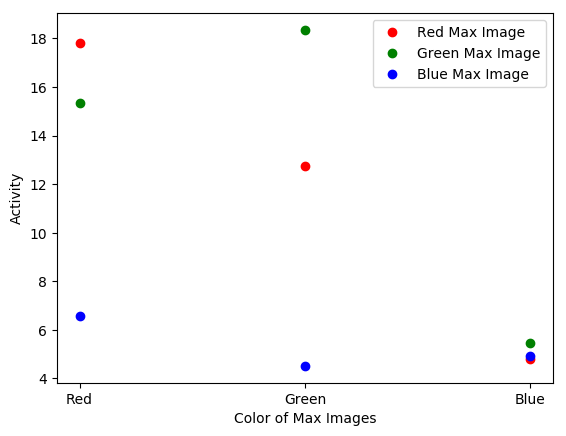

In [0]:
plt.style.use('default')
fig = plt.figure()

x = np.array([0,1,2])
my_xticks = ['Red','Green','Blue']
plt.xticks(x, my_xticks)

plt.plot(x, r_acts["avg"], "ro", g_acts["avg"], "go",b_acts["avg"], "bo")
# plt.plot(x, r_acts["max"], "r^", r_acts["avg"], "ro", g_acts["max"], "g^", g_acts["avg"], "go", b_acts["max"], "b^", b_acts["avg"], "bo")
plt.ylabel("Activity")
plt.xlabel("Color of Max Images")
plt.legend(["Red Max Image", "Green Max Image", "Blue Max Image"])
plt.show()

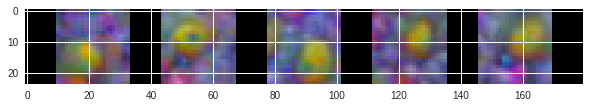

In [0]:
a2 = a
a2[0:2,:] = a2[26:28,:] = a2[:, 0:2] = a2[:, 26:28] = 0
plt.rcParams['figure.figsize'] = [10, 5]
top5 = get_NFsamples(a_2, image_a, 5)
plt.imshow(top5)
im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/top5_images.jpg'
save_image(top5, im_path)

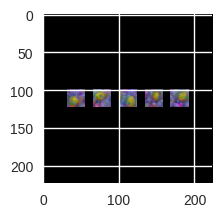

In [0]:
plt.rcParams['figure.figsize'] = [10, 5]
sample = np.zeros((224,224,3), dtype = np.uint8)
sample[100:124, 22:202, :]  = top5
plt.imshow(sample)
im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/top5full_images.jpg'
save_image(sample, im_path)

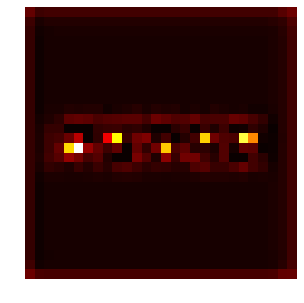

In [0]:
a_top5 = layer_vis.get_activations(sample, filter_num)
fig = plt.figure(frameon=False)
plt.axis('off')
plt.imshow(a_top5, cmap='hot', interpolation='nearest')

im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/top5act_images.jpg'
plt.savefig(im_path, dpi = 100, bbox_inches='tight', pad_inches=0)

In [0]:
(224 - 44) / 2 + 44

134.0

In [0]:
a2 = torch.clone(a)
a2[0:2,:] = a2[26:28,:] = a2[:, 0:2] = a2[:, 26:28] = 0
plt.rcParams['figure.figsize'] = [10, 5]
top1 = get_NFsamples(a2, image_a, 1)
sample = np.zeros((224,224,3), dtype = np.uint8)
sample[100:124, 90:134, :]  = top1
im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/top1full_images.jpg'
save_image(sample, im_path)

a_top1 = [torch.max(layer_vis.get_activations(zoom(sample, factor), filter_num)).item() for factor in [0.5, 0.75, 1, 1.25, 1.5, 2]]

# pickle.dump(a_top1, open("/content/gdrive/My Drive/generated/analysis/" + filter_pos + "/a_top1_zoom.p", "wb" ) )
# im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/top5full_images.jpg'
# save_image(sample, im_path)
# plt.imshow(top1)
# im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/top5_images.jpg'
# save_image(top5, im_path)


In [0]:
a_top1

[57.96073532104492,
 114.32145690917969,
 124.9559555053711,
 87.23558044433594,
 78.24608612060547,
 69.56250762939453]

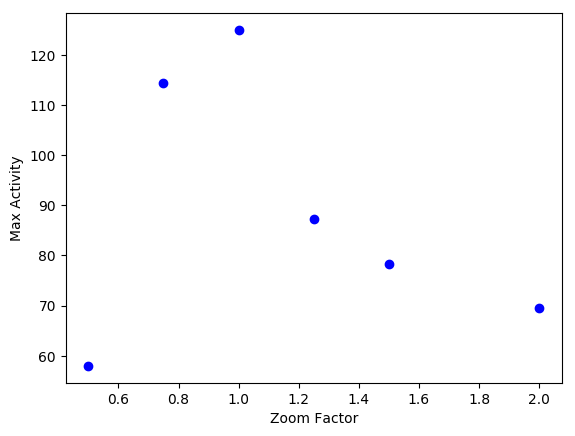

In [0]:
plt.style.use('default')
fig = plt.figure()

x = np.array([0.5, 0.75, 1, 1.25, 1.5, 2])

plt.plot(x, a_top1, "bo")
# plt.plot(x, r_acts["max"], "r^", r_acts["avg"], "ro", g_acts["max"], "g^", g_acts["avg"], "go", b_acts["max"], "b^", b_acts["avg"], "bo")
plt.ylabel("Max Activity")
plt.xlabel("Zoom Factor")
plt.show()

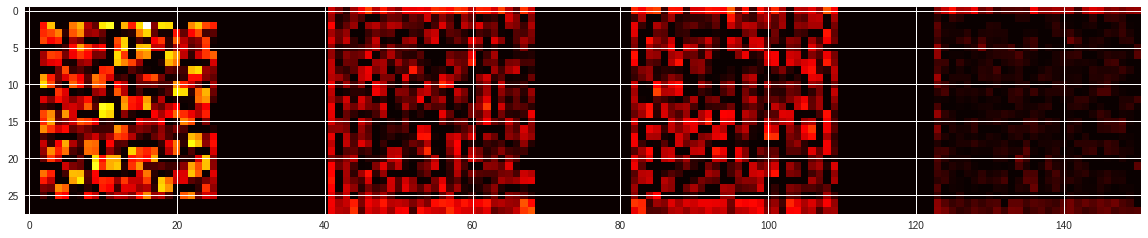

In [0]:
border = torch.zeros(28,13).cuda()
plt.rcParams['figure.figsize'] = [20, 10]
c = torch.cat((a, border, r, border, g, border, b), dim = 1)
c /= torch.max(c)
plt.imshow(c, cmap='hot', interpolation='nearest')

Run the visualizer for each filter 

If all three channels needed, the last argument to CNNLayerVisualization can be left empty or set colors_to_remove to None.
[0,1] removes the R and G channels and gives blue

In [0]:
activations = {"blur_radius" : 0.75, "layer" : 18, "color" : "blue"}
folder_name = "test"
colors_to_remove = None
for filter_pos in range(0, 1):
    cnn_layer = 18
    blur_radius = .75
    blur_every = 4
    print("layer is {} and filter is {}".format(cnn_layer, filter_pos))
    pretrained_model = models.vgg19(pretrained=True).cuda().features
    layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos, blur_radius, blur_every, colors_to_remove)

    # Layer visualization with pytorch hooks
    activations[filter_pos] = layer_vis.visualise_layer_with_hooks(folder_name)
    
pickle.dump(activations, open("/content/gdrive/My Drive/generated/" + folder_name + "/activations_layer18_0.75blur.p", "wb" ) )

layer is 18 and filter is 0
Iteration: 50 Loss: -111.77
